# Test

## 1. Transformers

Testing the usage instructions from https://huggingface.co/transformers/task_summary.html

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

result = classifier("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

result = classifier("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

In [ ]:
from transformers import pipeline

ner_pipe = pipeline("ner")

sequence = """Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO,
therefore very close to the Manhattan Bridge which is visible from the window."""

In [ ]:
print(ner_pipe(sequence))

In [ ]:
from transformers import TFAutoModelForTokenClassification, AutoTokenizer
import tensorflow as tf

model = TFAutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very" \
           "close to the Manhattan Bridge."

# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="tf")

outputs = model(inputs)[0]
predictions = tf.argmax(outputs, axis=2)

In [ ]:
for token, prediction in zip(tokens, predictions[0].numpy()):
    print((token, model.config.id2label[prediction]))

## 2. BERT

Testing instructions from https://huggingface.co/transformers/model_doc/bert.html

There are two groups of BERT modules. The standard one (BERT) uses PyTorch but we need the transformers version (TFBERT). 

In [ ]:
from transformers import BertTokenizer, TFBertForTokenClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertForTokenClassification.from_pretrained('bert-base-cased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
input_ids = inputs["input_ids"]
inputs["labels"] = tf.reshape(tf.constant([1] * tf.size(input_ids).numpy()), (-1, tf.size(input_ids))) # Batch size 1

outputs = model(inputs)
loss = outputs.loss
logits = outputs.logits

In [ ]:
logits

In [ ]:
outputs

In [ ]:
inputs

## 3. BERTje

Instructions: https://huggingface.co/GroNLP/bert-base-dutch-cased

Alternative models used by Bouma 2021: RobBERT (Delobelle), mBERT (Google), XLM-R (Conneau)

BERTje paper also mentions BERT-NL (textdata.nl)

In [ ]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = TFAutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # Tensorflow

In [ ]:
tokenizer.tokenize("Dit is een test.")

These instructions could be useful: 
* https://www.tensorflow.org/text/tutorials/classify_text_with_bert
* https://www.tensorflow.org/official_models/fine_tuning_bert

Even more: https://duckduckgo.com/?q=bert+tensorflow+text+classification

### 3.1 IMDB data set

Instructions: https://www.tensorflow.org/tutorials/keras/text_classification

In [ ]:
import os
import re
import shutil
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
os.listdir(dataset_dir)

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

FATAL ERROR!

### 3.2 Sentiment analysis

Instructions: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [31]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

Load IMDB data (skip)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Load social distancing data

In [32]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
DATA_DIR = 'social_distancing_relevance'

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    DATA_DIR,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    DATA_DIR,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 5977 files belonging to 2 classes.
Using 4782 files for training.
Found 5977 files belonging to 2 classes.


2021-07-20 11:43:31.667176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-20 11:43:31.667199: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-20 11:43:31.667215: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eslt0070): /proc/driver/nvidia/version does not exist
2021-07-20 11:43:31.667840: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using 1195 files for validation.


In [33]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b'RT @renevanm: Niet knuffelen, geen seks, 2 meter afstand houden... ik zit blijkbaar al geruime tijd in quarantaine.\n'
Label : 1 (RELEVANT)
Review: b'@Witty966 Ze volgen de onderzoeken niet of willen het niet weten!\\n\\n1.5 meter afstand helpt niets wanneer niet wordt geventileerd!\\n\\nhttps://t.co/u8Ga2Kpuoy\n'
Label : 1 (RELEVANT)
Review: b'@iOnAsJ @slecluyse @GeertNoels @Stijn_Baert ja inderdaad, gisteren dochter, echtgenoot, kleinkind thuis ontvangen, anderhalve meter? dat kon gewoonweg niet, meteen mondmasker aangedaan en ontsmettingsgel erbij genomen, maw...  zo was het niet gezellig. We gaan vrijwillig terug naar oude situatie. buiten aan de deur dus.\n'
Label : 1 (RELEVANT)


2021-07-20 11:43:32.072613: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-20 11:43:32.073469: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2899885000 Hz
2021-07-20 11:43:32.125209: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


This is the place where the BERT model is selected. There are mainly English language models available with one multi-lingual model which crashes the machine. No working Dutch models are found at the related website.   

In [34]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'

map_name_to_handle = {
    'wiki40b-lm-nl':
        'https://tfhub.dev/google/wiki40b-lm-nl/1',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'wiki40b-lm-nl':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [35]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3, Total size: 2.69MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'.


In [36]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 10531 10124 11049 10151 28149 19308 18379   106   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [37]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3: 30.00MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3: 60.00MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3: 90.00MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3: 120.00MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3: 150.00MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3: 180.00MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3: 210.00MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3: 240.00MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3: 270.00MB
INFO:absl:Downloading https://tfhub.

In [38]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.6052361  -0.03562833  0.34877217 -0.41043743 -0.39114502  0.52867943
  0.4629631   0.08782487 -0.47338453  0.35345632 -0.06693023 -0.27646577]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.33073407  0.14612621 -0.06266934 ...  0.84484535 -0.12296543
   0.77432895]
 [-0.8536666  -0.01048076 -0.10002846 ...  0.4412018  -0.23505431
   0.6783054 ]
 [-0.7773089   0.40002573 -0.17473161 ...  0.7971061  -0.21617687
   0.8154314 ]
 ...
 [-0.53897893  0.20686042  0.33575624 ...  0.5694974  -0.24205497
   0.53376555]
 [-0.5707657   0.10813653  0.18492147 ...  0.8677025  -0.16494572
   0.56380117]
 [-0.56603634  0.1004438   0.17902762 ...  0.80625296 -0.11992311
   0.53856736]]


In [39]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [40]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

2021-07-20 11:52:22.728585: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 367248384 exceeds 10% of free system memory.


tf.Tensor([[0.8319441]], shape=(1, 1), dtype=float32)


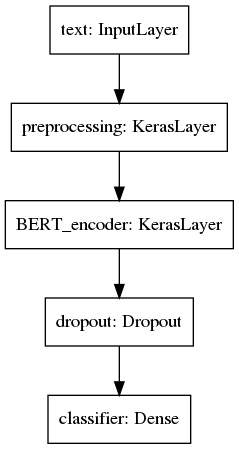

In [41]:
tf.keras.utils.plot_model(classifier_model)

In [42]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [43]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [44]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

This takes a lot of time (5 hours for imdb data), so skip it

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/5
 77/150 [==============>...............] - ETA: 36:14 - loss: 0.5546 - binary_accuracy: 0.7277

Results for social distancing data on training data:

| type | classes | 1 | 2 | 3 | 4 | 5 |
| -- | -- | -- | -- | -- | -- | -- |
| bert_en_uncased_L-12_H-768_A-12  | 3 | 0.550 | 0.565 | 0.580 | 0.580 | 0.587 |
| bert_multi_cased_L-12_H-768_A-12 | 3 | 0.536 | 0.554 | 0.571 | 0.599 | 0.616  |
| bert_multi_cased_L-12_H-768_A-12 | 2 | 0.791 | 0.797 | 0.843 | | |

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'social_distancing'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Resume processing here:

In [ ]:
dataset_name = 'social_distancing'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'iedereen moet afstand houden',  # this is the same sentence tried earlier
    'hou afstand',
    'niemand houdt afstand',
    'de afstand tot het doel is 11 meter',
    'ze moeten stoppen met maatregelen als 1,5 m'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
# original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
# print('Results from the model in memory:')
# print_my_examples(examples, original_results)

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

### 3.3 Prepare data for tensorflow

In [ ]:
import os
import pandas as pd

In [ ]:
DATA_DIR_IN = "../../puregome/data/annotation/"
TEXT_FILE = os.path.join(DATA_DIR_IN, "distance-tweets.csv")
LABEL_FILE = TEXT_FILE + ".human-labels.txt"
DATA_DIR_OUT = "social_distancing/"

In [ ]:
def extract_data(text_df, label_df):
    data_dict = {}
    target_annotator = ""
    for i, row in label_df.iterrows():
        if target_annotator == "":
            target_annotator = row["annotator"]
        if row["id_str"] in text_df.index and row["annotator"] == target_annotator:
            data_dict[row["id_str"]] = { "label": row["label"], "text": text_df.loc[row["id_str"]]["text"] }
    return data_dict

In [ ]:
def store_data(data_dict):
    for id_str in data_dict:
        out_dir = os.path.join(DATA_DIR_OUT, data_dict[id_str]["label"])
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
        out_file = open(os.path.join(out_dir, str(id_str) + ".txt"), "w")
        print(data_dict[id_str]["text"], file=out_file)
        out_file.close()

In [ ]:
text_df = pd.read_csv(TEXT_FILE, index_col="id_str")
label_df = pd.read_csv(LABEL_FILE, sep=" ", header=None, names=["annotator", "date", "id_str", "data_set_id", "label"])
data_dict = extract_data(text_df, label_df)

In [ ]:
len(data_dict)

This stores the tweets in subdirectories of `social_distancing` where the names of the subdirectories are equal to the labels and where each tweet is stored in a file named `id_str.txt`

In [ ]:
store_data(data_dict)

## 4. ROBBERT

Instructions: https://huggingface.co/pdelobelle/robbert-v2-dutch-base and https://github.com/iPieter/RobBERT

Requires PyTorch: https://pytorch.org/<br>
Installation command (select: pip & CPU): `pip3 install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html`

In [1]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base")

Downloading:   0%|          | 0.00/660 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.weight', 'class

In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [3]:
logits


tensor([[ 0.1636, -0.0760]], grad_fn=<AddmmBackward>)

In [16]:
tokenizer("Dit is een test!")['input_ids']

[0, 495, 405, 16, 364, 225, 1296, 328, 2]

In [19]:
tokenizer.decode([0, 495, 405, 16, 364, 225, 1296, 328, 2])

'<s>Dit is een test!</s>'

In [20]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained('roberta-base')

inputs = tokenizer("The capital of France is <mask>.", return_tensors="pt")
labels = tokenizer("The capital of France is Paris.", return_tensors="pt")["input_ids"]

outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

In [21]:
logits

tensor([[[34.8744, -3.8884, 18.9567,  ...,  2.8639,  5.2812, 11.2557],
         [ 8.5224, -2.9420, 19.8858,  ...,  2.7513,  4.0812,  8.5191],
         [-3.2755, -4.2489,  9.6843,  ..., -1.3403, -2.0838, -0.4035],
         ...,
         [-4.8167, -3.8881,  8.3117,  ..., -4.3991, -5.6916,  1.1575],
         [20.6686, -4.4710, 20.3602,  ...,  0.9624,  3.1282,  7.1575],
         [11.6269, -3.6408, 32.1565,  ...,  2.0802, -0.2959,  9.1577]]],
       grad_fn=<AddBackward0>)